# Import necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load The smartphone users features dataset

In [3]:
df = pd.read_csv('../data/cleaned/smartphone_users_features.csv')
df.head(10)

,user,avg_data_before_upgrade,std_before,total_recharge_before,avg_data_after_upgrade,std_after,total_recharge_after,days_active_after,time_to_first_data_use,recharge_growth
0,225798765432,0.130697,0.452746,3091.482637,282355.658691,746850.094482,10600.000000,14,0,7508.517363
1,225798765433,NaN,NaN,NaN,390674.369565,760990.974794,15979.550000,10,0,NaN
2,225798765434,NaN,NaN,NaN,77583.160156,109719.157305,275.000000,1,0,NaN
3,225798765435,0.261393,0.452746,450.000000,156755.774613,284752.858237,25581.482637,26,0,25131.482637
4,225798765436,7.143986,32.579923,13800.000000,42745.234739,113248.911365,32883.892637,23,0,19083.892637
5,225798765437,NaN,NaN,NaN,335146.056456,444032.000989,68208.170000,53,0,NaN
6,225798765438,16.537679,57.288201,4365.000000,95417.883423,226608.350722,21665.000000,10,0,17300.000000
7,225798765439,0.000000,0.000000,300.000000,166845.815390,380647.458232,14318.000000,20,0,14018.000000
8,225798765440,NaN,NaN,NaN,0.499023,0.705726,600.000000,1,30,NaN
9,225798765441,0.000000,0.000000,900.000000,103312.879907,220188.867402,25413.652637,18,0,24513.652637


# EDA

Let's see how much data users used before upgrade

<Axes: title={'center': 'Average Data Usage Before Upgrade'}, xlabel='Average Data Usage (kb)', ylabel='Frequency'>

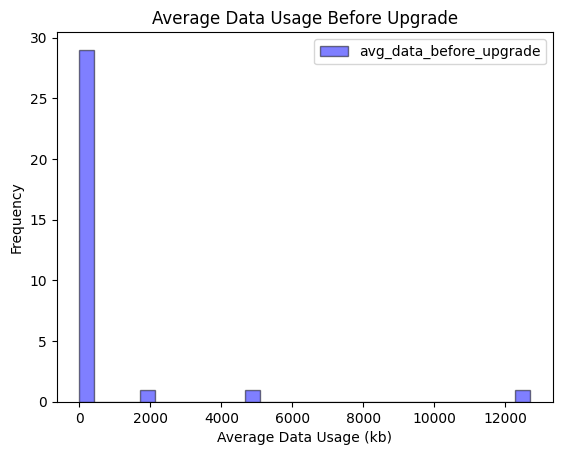

In [4]:
df['avg_data_before_upgrade'].dropna().plot(kind='hist', bins=30, alpha=0.5, color='blue', edgecolor='black', title='Average Data Usage Before Upgrade', xlabel='Average Data Usage (kb)', ylabel='Frequency', legend=True)

#### **Observations: Data Usage Before Upgrade**

1. Majority of users had very low average daily data usage this means before upgrading almost nobody was using internet
2. Few users (1-3) had a higher avaerage daily  usage (might be outliers)
3. The distribution is right-skewed

Let's see how much data users used after upgrade

<Axes: title={'center': 'Histogram of Data Usage After Upgrade'}, xlabel='Data Usage (kb)', ylabel='Frequency'>

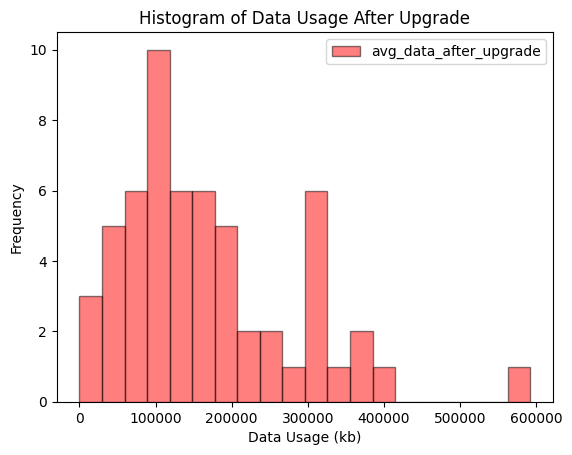

In [5]:
df['avg_data_after_upgrade'].dropna().plot(kind='hist', bins=20, alpha=0.5, color='red', edgecolor='black', title='Histogram of Data Usage After Upgrade' , xlabel='Data Usage (kb)', ylabel='Frequency', legend=True)

#### **Observations: Data Usage After Upgrade**

1. Alot of users consume between 10000 kb to 200000 kb (10 Mb to 200 Mb) of data daily
2. The distrubution is right skewed
3. Few users (1 user) used 500 000+ kb which is around 500Mb+

See how recharge behavior changed

<Axes: title={'center': 'Recharge Growth Distribution'}, xlabel='Recharge Growth', ylabel='Frequency'>

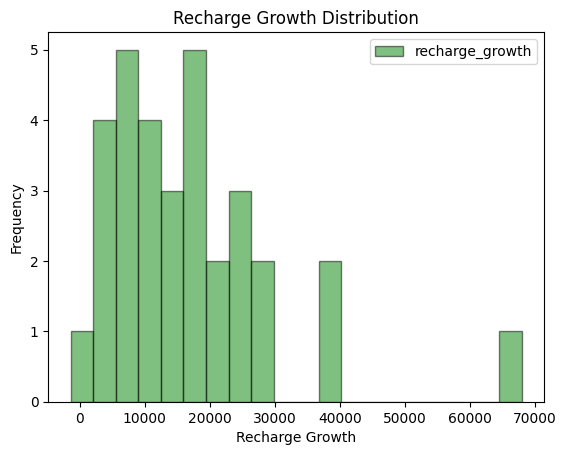

In [6]:
df['recharge_growth'].dropna().plot(kind='hist', bins=20, alpha=0.5, color='green', edgecolor='black' , title='Recharge Growth Distribution' , xlabel='Recharge Growth', ylabel='Frequency', legend=True)

#### **Observations: Recharge Growth**

1. Most users had recharge growth between 0 and 30,000.
2. A few users showed extreme recharge increases, indicating either heavy new usage or specific promotions.
3. The distributation is right skewed

Let's see te distribution of days_active_after the upgrade

<Axes: title={'center': 'Days Active After Upgrade Distribution'}, xlabel='Days Active After Upgrade', ylabel='Frequency'>

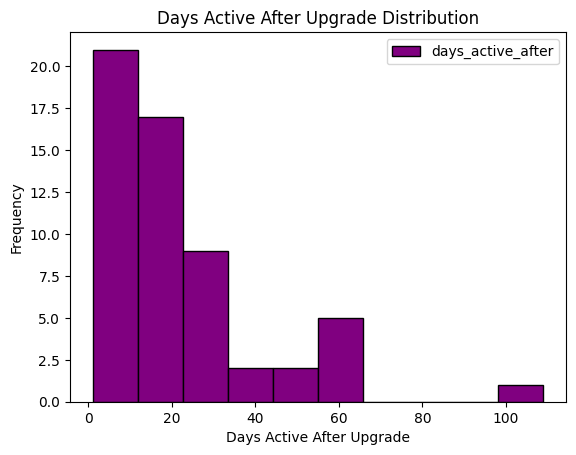

In [7]:
df['days_active_after'].dropna().plot(kind='hist', color='purple', edgecolor='black' , title='Days Active After Upgrade Distribution' , xlabel='Days Active After Upgrade', ylabel='Frequency', legend=True) 

#### **Observations: Days Active After Upgrade**

1. Most users were active between 0–30 days after upgrading.
2. Very few users maintained activity for over 60+ days.
3. The distribution is right skewed which tell us that many users are moving away of mobile data.

#### **Indentify Growers and non-growers a 50% growth is considered**

Let's first fill nan rows in avg_data_upgrade by 0

**Reason:📌**

--> User has no internet activity before the upgrade

--> Missing record. 

so fill their records of data usage before upgrade with 0 won't affect the program 

**⚠️ Issue with this approach:**

--> Users with no usage records before upgrade now are considered like those who had a few usage before the upgrade which mathematical sounds right but wrong in business logics. 

--> It's wrong to consider them  as growers but we can insist that they're starters

**🔥 Action:**

--> No filling nan value instead consider those users as none growers

> | NaN = "Never seen",

> | 0.00 = "Seen but idle".


In [8]:
df['increased_usage'] = (
    (df['avg_data_before_upgrade'].notna()) &
    (df['avg_data_before_upgrade'] > 0) &
    (df['avg_data_after_upgrade'] > df['avg_data_before_upgrade']*1.5)
    ).astype(int)

# User segmentation

Let's divide user's into non , low , medium and high adopters.

> if data_after == 0 then = non

🔄 **wait** 

. a user using 0.4kb/day is still considered as a low adopter that's unrealistic in this modern world we need a threshold

> No threshold needed , as they're accidental net users so keep this as it is

**Segment | Condition | Meaning**

Non-user | avg_data_after_upgrade == 0 | Never used data

Low adopter | Usage ≤ 25th percentile | Very small users

Medium adopter | Usage between 25th and 75th percentile | Average users

High adopter | Usage > 75th percentile | Heavy users

<Axes: title={'center': 'User Segmentation After Upgrade'}, xlabel='User Segment', ylabel='Count'>

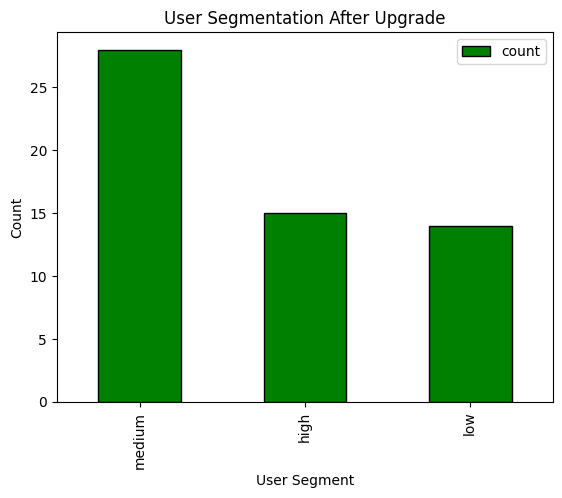

In [ ]:
low_threshold = df['avg_data_after_upgrade'].quantile(0.25)
high_threshold = df['avg_data_after_upgrade'].quantile(0.75)

def segment_users(row):
    usage = row['avg_data_after_upgrade']
    
    if usage == 0:
        return 'non'
    elif usage < low_threshold:
        return 'low'
    elif usage < high_threshold:
        return 'medium'
    else:
        return 'high'
    
df['user_segment'] = df.apply(segment_users, axis=1)
df['user_segment'].value_counts().plot(kind='bar', color='green', edgecolor='black', title='User Segmentation After Upgrade', xlabel='User Segment', ylabel='Count', legend=True)

#### **Observations: Quantile-Based User Segments**

- Low adopters: Users between 0 and 25th percentile of data usage after upgrade. = 14

- Medium adopters: Users between 25th and 75th percentile. = 28

- High adopters: Users above the 75th percentile. = 15

- Non adopters: Users with zero mobile data usage (none found in dataset). = 0

- This segmentation provides a more balanced and behaviorally accurate view of the user compared to arbitrary thresholds.

- The majority started consuming data heavily after upgraded.

- No need for onboarding campaigns (or Tips on how to use internet) as we don't have non-users segment in the current dataset

#### Let's Analyse Recharge growth by segment

Plot this analysis by grouping users based on their segment and see who recharges more ofte other

/tmp/ipykernel_98100/4083468483.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='user_segment', y='recharge_growth', data=df, palette='Set2')


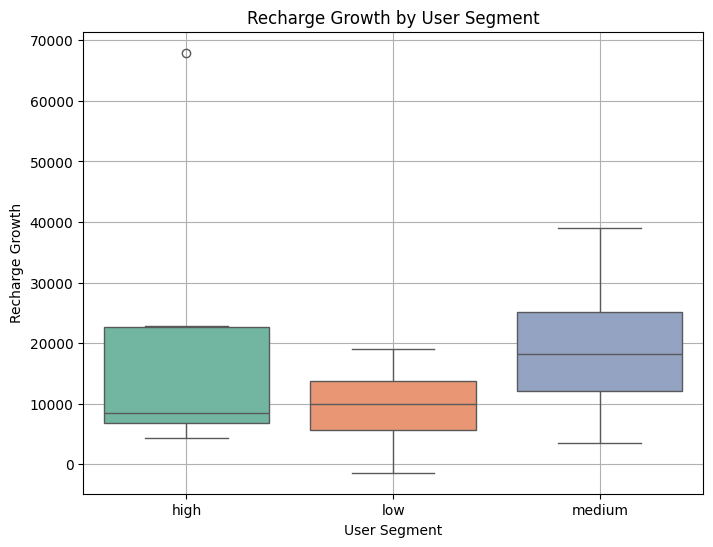

In [10]:
plt.figure(figsize=(8,6))
sns.boxplot(x='user_segment', y='recharge_growth', data=df, palette='Set2')
plt.title('Recharge Growth by User Segment')
plt.xlabel('User Segment')
plt.ylabel('Recharge Growth')
plt.grid(True)
plt.show()

In [11]:
pd.crosstab(df['user_segment'], df['increased_usage'], normalize='index') * 100

increased_usage,0,1
user_segment,,
high,80.000000,20.000000
low,78.571429,21.428571
medium,75.000000,25.000000


**Observations: Recharge growth by user segment**

- Medium adopters have the highest median recharge growth, showing strong and stable usage after upgrade.
- High adopters display a wide range in recharge growth, with some extreme outliers, suggesting inconsistent usage behavior.
- Low adopters generally top-up less, with some users even reducing recharge activity after upgrading.
- Non adopters are not found in the current dataset



# 🔑 Key Insights

- Medium adopters are the most stable and growing group — prime candidates for upsell and engagement.

- High adopters show potential but need personalized offers due to unpredictable recharge behavior.

- Low adopters may need small bonus bundles or educational campaigns to grow further.

#### Display the correleration of the data frame

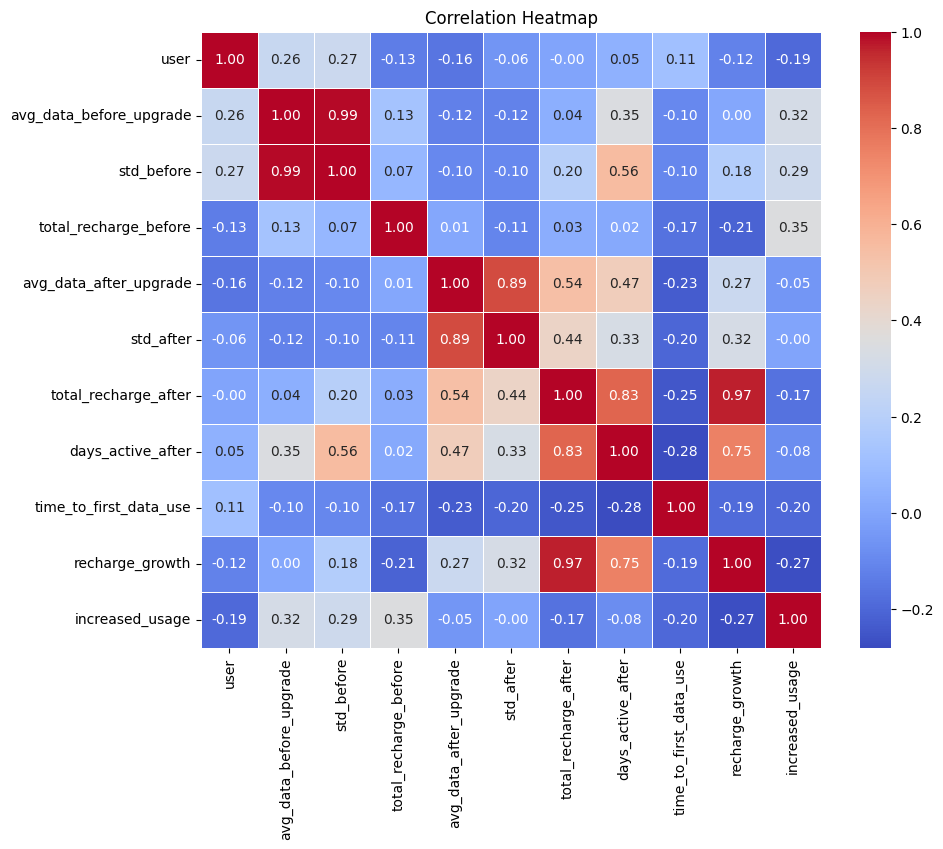

In [20]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Answers to all questions asked in the project description doc under phase 2

> q1. How many new smartphone users use data at all?

`All 57 users used data after upgrading to a smartphone, we don't have avg_data_after_upgrade == 0 showing that all users adopted data`

> q2. What % increased their data usage after the upgrade?

`Approximately 23% of users (13 users out of 57 users) increased their data usage.`

> q3. Are there common traits among low vs high adopters?

`Yes — based on data usage, recharge growth, and increased usage:`

store the current dataframe in csv, call it users_usage_segmented.csv

In [21]:
df.to_csv('../data/cleaned/users_usage_segmented.csv', index=False)